<a href="https://colab.research.google.com/github/blossomsu/CASA0025Building_Spatial_Applications_with_Big_Data/blob/main/automl/automl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mljar-supervised

用机器学习来预测 OD flow（F_ij），
不假设任何引力公式结构，
让数据自己学关系，
然后用 stacking 得到最优预测。

This workflow is really simple..

In [2]:
# import libraries
import pandas as pd
import numpy as np

from supervised.automl import AutoML

In [3]:
# make sure we can see the plots
%matplotlib inline

In [4]:
# mount to Google Drive so we can import the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# read in the data wherever you stored it
df = pd.read_csv(
    "https://github.com/asrenninger/urbansim/raw/main/automl/migration.csv.gz",
    compression="gzip"
)

In [6]:
# or you can read it in from github
# df = pd.read_csv("https://github.com/asrenninger/urbansim/raw/main/automl/migration.csv.gz")

In [7]:
# I'm listing the columns so below I can see what I want to keep
df.columns

Index(['code_i', 'code_j', 'F_ij', 'distance', 'name_i', 'name_j', 'density_i',
       'married_i', 'households_i', 'population_i', 'nonwhite_i',
       'unhealthy_i', 'employed_i', 'university_i', 'density_j', 'married_j',
       'households_j', 'population_j', 'nonwhite_j', 'unhealthy_j',
       'employed_j', 'university_j'],
      dtype='object')

AutoML has several modes—Explain, Perform, Compete. They all use different combinations of models to create the best prediction. The lightest, fastest possible collection of models is Explain, so we will stick with that to make it run faster.

In [8]:
# create training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # we are going to throw out the first 2 columns
    df[df.columns[3:]], df["F_ij"], test_size=0.25 #75% 数据训练，25% 数据测试
)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="drive/MyDrive/urbansim/automl", mode='Explain')
# fit the model
automl.fit(X_train, y_train)

#AutoML是一个自动化流程系统，用来自动训练、调参、比较、并组合多个模型

# AutoML自动：
# 自动特征预处理
# 训练 Random Forest
# 训练 XGBoost
# 训练 LightGBM
# 训练神经网络
# 做交叉验证
# 比较 R²
# 选择最佳模型
# 做 stacking
# 输出最终预测器

Linear algorithm was disabled.
This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


See that AutoML saves the model as to your folder. Go to the directory and check out the model. There should be Feature Importance images in each model folder. These compute the "importance" of each variable by shuffling them one-by-one and seeing how much a completely random version hurts model performance. What are some important features?

In [9]:
# let's store predictions
y_pred = automl.predict(X_test)

There are lot of model evaluation metrics in [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [10]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score
# percent error
print(mean_absolute_percentage_error(y_test, y_pred))
# absolute error
print(median_absolute_error(y_test, y_pred))
# r-squared
print(r2_score(y_test, y_pred))

1.4582563912120592
4.686361847155499
0.8302595122011502


Why do you think these are useful metrics, compared to something like RMSE?

In [11]:
# bin the predictions so we can see which parts of the distribution we are predicting best with
y_eval = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
y_eval['quantile'] = pd.qcut(y_eval['y_test'], 10, duplicates='drop')
y_eval['quantile'] = y_eval['quantile'].apply(lambda x: x.mid)

/tmp/ipython-input-1186874090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


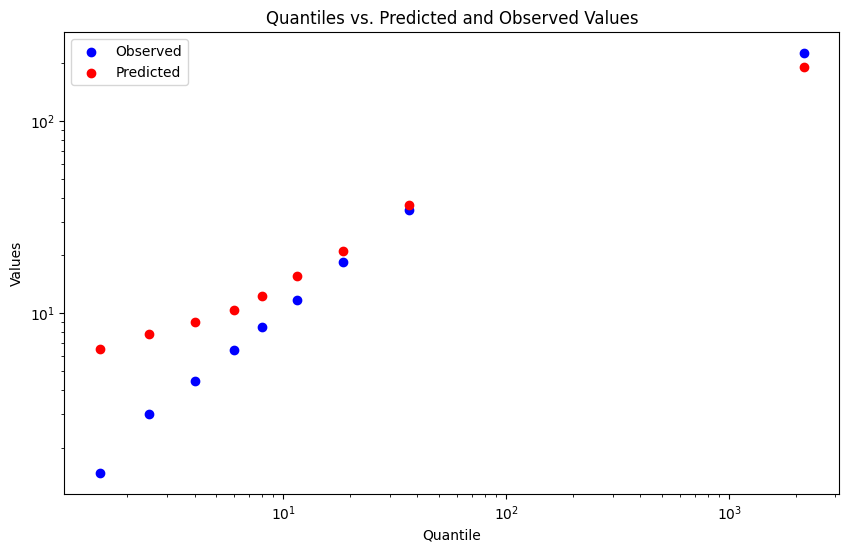

In [12]:
# average error per quantile
y_tile = y_eval.groupby('quantile', as_index=False).agg({'y_pred': 'mean', 'y_test': 'mean'})

import matplotlib.pyplot as plt
# sort the DataFrame by decile for plotting
y_tile.sort_values('quantile', inplace=True)

# create a figure and an axes instance
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot for observed values on ax
ax.scatter(y_tile['quantile'], y_tile['y_test'], color='blue', label='Observed')

# scatter plot for predicted values on ax
ax.scatter(y_tile['quantile'], y_tile['y_pred'], color='red', label='Predicted')

# adding labels and legend
ax.set_xlabel('Quantile')
ax.set_ylabel('Values')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

# show plot
plt.show()

It seems like we are predicting well everywhere except the low end of the distribution

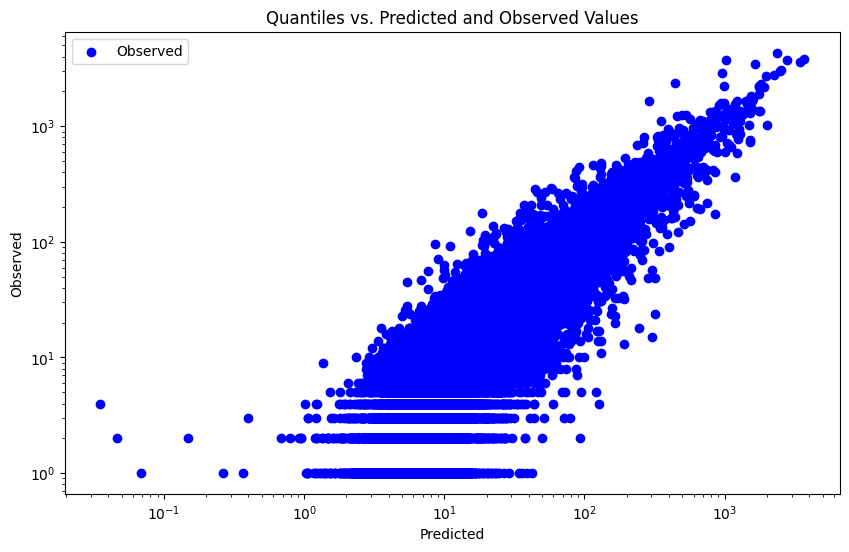

In [13]:
# predictions against observations
y_eval.sort_values('quantile', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_eval['y_pred'], y_eval['y_test'], color='blue', label='Observed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

plt.show()

# Challenge

Create a new folder called "perform", then run AutoML again with a new results_path but instead of "Explain" use "Perform" as its mode. This will use more models in the stacking and should get better results. Show some metrics from `sklearn`and plot some results; can you show that the new "Perform" model did better or worse?

In [20]:
# create training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # we are going to throw out the first 2 columns
    df[df.columns[3:]], df["F_ij"], test_size=0.25 #75% 数据训练，25% 数据测试
)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="drive/MyDrive/urbansim/perform", mode='Perform')
# fit the model
automl.fit(X_train, y_train)

Linear algorithm was disabled.
AutoML directory: drive/MyDrive/urbansim/perform
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models
1_Default_LightGBM rmse 75.251158 trained in 77.77 seconds (1-sample predict time 0.0409 seconds)
2_Default_Xgboost rmse 75.658765 trained in 50.77 seconds (1-sample predict time 0.0613 seconds)
3_Default_CatBoost rmse 70.907836 trained in 53.86 seconds (1-sample predict time 0.0506 seconds)
4_Default_NeuralNetwork rmse 90.071629 trained in 33.13 seconds (1-sample predict time 0.0786 seconds)
5_Default_RandomForest rm

AutoML(mode='Perform', results_path='drive/MyDrive/urbansim/perform')

In [21]:
# let's store predictions
y_pred = automl.predict(X_test)

In [22]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score
# percent error
print(mean_absolute_percentage_error(y_test, y_pred))
# absolute error
print(median_absolute_error(y_test, y_pred))
# r-squared
print(r2_score(y_test, y_pred))

1.0044395251670144
3.5861600198992147
0.7898513479261455


In [23]:
# bin the predictions so we can see which parts of the distribution we are predicting best with
y_eval = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
y_eval['quantile'] = pd.qcut(y_eval['y_test'], 10, duplicates='drop')
y_eval['quantile'] = y_eval['quantile'].apply(lambda x: x.mid)

/tmp/ipython-input-1186874090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


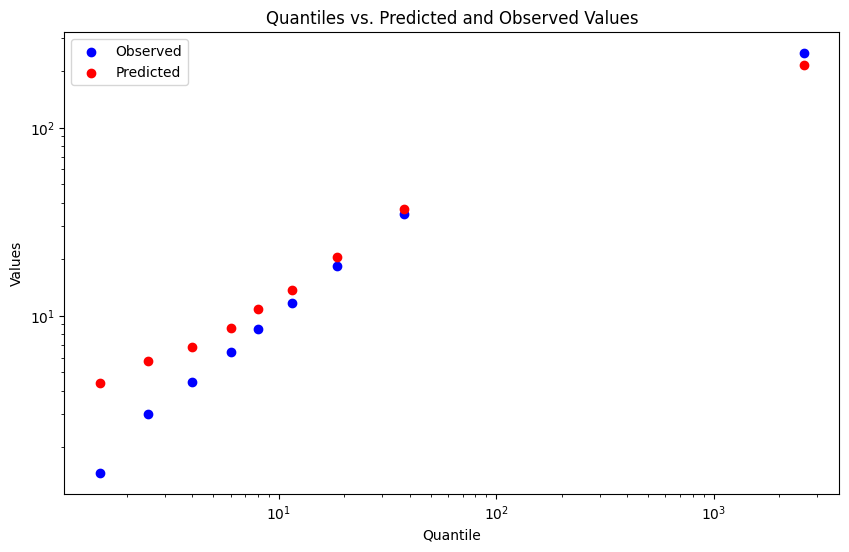

In [24]:
# average error per quantile
y_tile = y_eval.groupby('quantile', as_index=False).agg({'y_pred': 'mean', 'y_test': 'mean'})

import matplotlib.pyplot as plt
# sort the DataFrame by decile for plotting
y_tile.sort_values('quantile', inplace=True)

# create a figure and an axes instance
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot for observed values on ax
ax.scatter(y_tile['quantile'], y_tile['y_test'], color='blue', label='Observed')

# scatter plot for predicted values on ax
ax.scatter(y_tile['quantile'], y_tile['y_pred'], color='red', label='Predicted')

# adding labels and legend
ax.set_xlabel('Quantile')
ax.set_ylabel('Values')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

# show plot
plt.show()

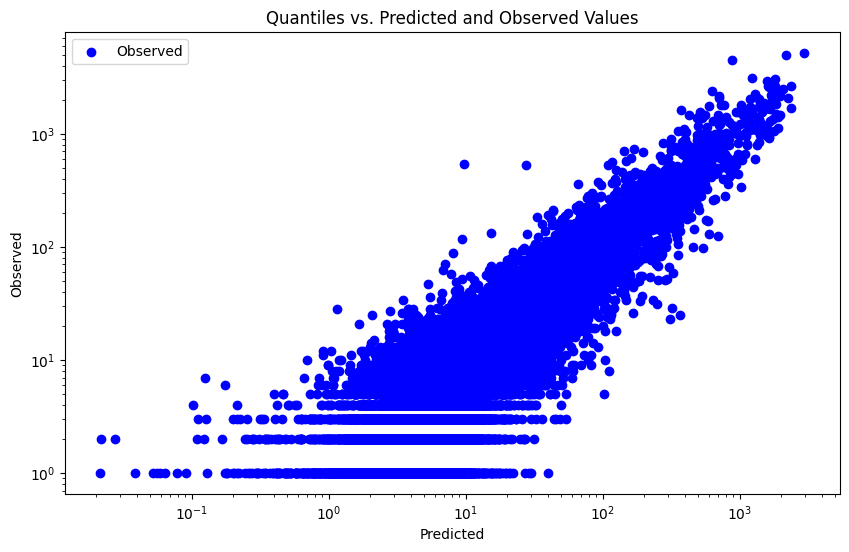

In [25]:
# predictions against observations
y_eval.sort_values('quantile', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_eval['y_pred'], y_eval['y_test'], color='blue', label='Observed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

plt.show()

**Perform:**

1.尝试更多参数

2.自动 feature engineering（golden features）

3.多轮 hill climbing

4.更复杂 stacking



MAPE = 1.0044

Median Absolute Error = 3.5862

R² = 0.7899

RMSE: 63.4145

**Explain:**

MAPE = 1.4583

Median Absolute Error = 4.6864

R² = 0.8303

RMSE = 74.0433

分别使用 AutoML 的 “Explain” 模式与 “Perform” 模式对空间流动数据进行了建模，并对模型效果进行了比较。从 RMSE 指标来看，Explain 模式下的最优模型（Ensemble）RMSE 为 74.04，而 Perform 模式下降至 63.41，误差降低约 15%，说明 Perform 模式在整体预测精度上有明显提升。由于 RMSE 对大流量误差更加敏感，这一结果表明 Perform 模式在高值区间的拟合能力有所增强。

然而，从部分 sklearn 计算的测试集指标来看，Explain 模式的 R² 为 0.83，而 Perform 模式为 0.79，略有下降。这可能反映出 Perform 模式在某些分布区间（尤其是极端大值或尾部区域）上的拟合波动。同时，Perform 模式的中位绝对误差（Median Absolute Error）较低，说明其在典型流动规模上的预测更加稳定。